# Mitsubishi reverse cycle heat pump

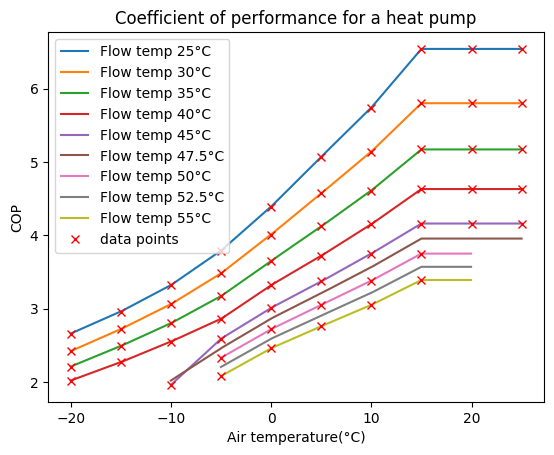

In [20]:
from Modules.Heating import Heat_Pump
import matplotlib.pyplot as plt
import Modules.Data as Data
import numpy as np

Heat_Pump = Heat_Pump("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Heating_5C.csv")

COP_interp = Heat_Pump.interp_init("COP")

air_temp = np.linspace(-20, 25, 1000)
hydronics_temp = [25, 30, 35, 40, 45, 47.5, 50, 52.5, 55]

for output_temp in hydronics_temp:

    COP = Heat_Pump.Calculate_COP(output_temp, air_temp, COP_interp)
    
    plt.plot(air_temp, COP, label = 'Flow temp ' + str(output_temp) + '°C')
    
# data points
data_air_temp = Data.column_from_csv("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Heating_5C.csv", "Air temperature(°C)")

data_flow_temp = Data.column_from_csv("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Heating_5C.csv", "Flow temperature(°C)") 

data_COP = Heat_Pump.Calculate_COP(data_flow_temp, data_air_temp, COP_interp)

plt.plot(data_air_temp, data_COP, label = "data points", marker='x', color='red', linestyle='None')

plt.title('Coefficient of performance for a heat pump')
plt.xlabel('Air temperature(°C)')
plt.ylabel('COP')
plt.legend()

Number of fan coils required: 64
Total electricity usage nan kWh/yr
Effective COP: nan


Text(0, 0.5, 'Capped heating requirement (kW)')

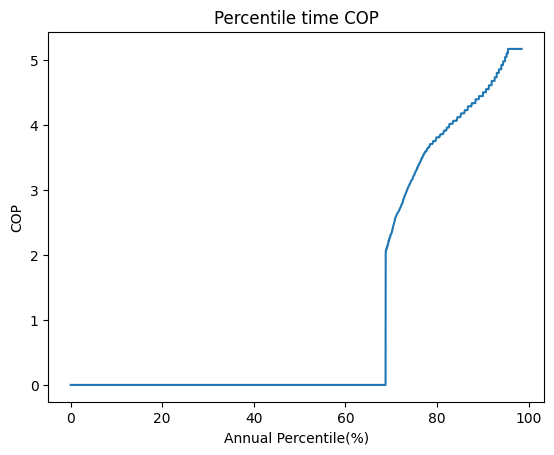

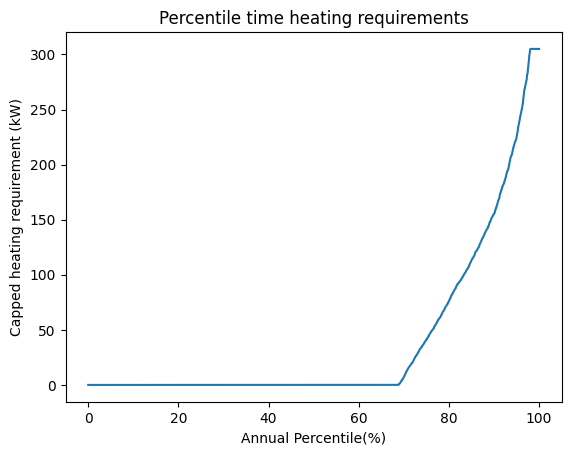

In [21]:
from Modules.Heating import Heat_Pump
from Modules.Heating import Reverse_HP_Controller
from Modules.Heating import Heating_Distribution
import numpy as np
import matplotlib.pyplot as plt

max_HP_power = 305 # in kW
max_HVAC_power = 175 # in kW
max_hydronics_temp = 55 # based off of operating conditions of heat pump

Heat_Pump = Heat_Pump("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Heating_5C.csv")

Heating_Distribution = Heating_Distribution("Data/HFP-550LM-Z1", max_HP_power, max_HVAC_power)

Controller = Reverse_HP_Controller(Heat_Pump, Heating_Distribution, max_HP_power, max_HVAC_power)

time, heating, electricity, COP, air_temp, hydronics_temp = Controller.controller()

print('Total electricity usage ' + str(np.sum(electricity)) + ' kWh/yr')

effective_COP = np.sum(heating) / np.sum(electricity)
print('Effective COP: ' + str(effective_COP))


# Plotting stuff - maybe don't need now?

# When heating is zero set COP to 0
indices = [i for i, x in enumerate(heating) if x == 0]
COP[indices] = 0

plt.figure(0)
plt.plot(100 * time / np.max(time), np.sort(COP))
plt.title("Percentile time COP")
plt.xlabel('Annual Percentile(%)')
plt.ylabel('COP')
# plt.figure(1)
# plt.plot(time, heating)
# plt.figure(2)
# plt.plot(time, electricity)
plt.figure(3)
plt.plot(100 * time / np.max(time), np.sort(heating))
# plt.plot(99, 305, marker='x', color='red')
plt.title('Percentile time heating requirements')
plt.xlabel('Annual Percentile(%)')
plt.ylabel('Capped heating requirement (kW)')